In [1]:
import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean
from gsw import sigma0
from xhistogram.xarray import histogram
from gsw import SA_from_SP
from gsw import sigma2
from gsw import CT_from_t
from gsw import p_from_z
import logging
from xhistogram.xarray import histogram
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=28, memory_limit='380GiB')

2024-06-03 15:28:04,233 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 380GiB due to system memory limit of 251.18 GiB
2024-06-03 15:28:04,240 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 380GiB due to system memory limit of 251.18 GiB
2024-06-03 15:28:04,243 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 380GiB due to system memory limit of 251.18 GiB
2024-06-03 15:28:04,303 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 380GiB due to system memory limit of 251.18 GiB
2024-06-03 15:28:04,307 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 380GiB due to system memory limit of 251.18 GiB
2024-06-03 15:28:04,311 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 380GiB due to system memory limit of 251.18 GiB
2024-06-03 15:28:04,315 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 380GiB due to system memory limit of 251.18 GiB
2024-0

In [3]:
exp = '01deg_jra55v140_iaf_cycle3'
lat_range = slice(-90,-59)
isobath_depth = 1000
session = cc.database.create_session()
yu_ocean = cc.querying.getvar(exp,'yu_ocean',session,n=1).sel(yu_ocean=lat_range)
xu_ocean = cc.querying.getvar(exp,'xu_ocean',session,n=1)

Importing $T$, $S$ and $age$

In [4]:
%%time
#later on change for a full import
start_time='1958-01'
end_time='1958-12'
time_slice=slice(start_time,end_time)
#Setting the chuncksize along time
Timevar = cc.querying.getvar(exp,'temp',session,start_time=start_time,end_time=end_time,frequency='1 monthly').sel(time=time_slice).time
time_length=np.size(Timevar)
chunknumber=int(28/time_length)

T = cc.querying.getvar(exp,'temp',session,start_time=start_time,end_time=end_time,frequency='1 monthly').sel(time=time_slice).sel(yt_ocean=lat_range)-273.15
S = cc.querying.getvar(exp,'salt',session,start_time=start_time,end_time=end_time,frequency='1 monthly').sel(time=time_slice).sel(yt_ocean=lat_range)

AGE = cc.querying.getvar(exp,'age_global',session,start_time=start_time,end_time=end_time,frequency='1 monthly').sel(yt_ocean=lat_range).sel(time=time_slice)
tarea = cc.querying.getvar(exp,'area_t',session,n=1).sel(yt_ocean=lat_range)
dzt = cc.querying.getvar(exp,'dzt',session,start_time=start_time,end_time=end_time,frequency='1 monthly').sel(yt_ocean=lat_range).sel(time=time_slice)
tvol=dzt*tarea

# #interpolating T,S,AGE to UV points
tvol_u=tvol.interp(xt_ocean=xu_ocean).drop_vars('xt_ocean');tvol_v=tvol.interp(yt_ocean=yu_ocean).drop_vars('yt_ocean')
T_u=T.interp(xt_ocean=xu_ocean).drop_vars('xt_ocean'); T_v=T.interp(yt_ocean=yu_ocean).drop_vars('yt_ocean')
S_u=S.interp(xt_ocean=xu_ocean).drop_vars('xt_ocean'); S_v=S.interp(yt_ocean=yu_ocean).drop_vars('yt_ocean')
AGE_u=AGE.interp(xt_ocean=xu_ocean).drop_vars('xt_ocean'); AGE_v=AGE.interp(yt_ocean=yu_ocean).drop_vars('yt_ocean')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

CPU times: user 25.6 s, sys: 5.86 s, total: 31.5 s
Wall time: 1min 29s


Importing 1km isobath contour

In [5]:
	
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_'+str(isobath_depth)+'m.npz'
cutout_latind=510
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']; 
mask_y_transport=mask_y_transport[:cutout_latind,:]       ##############################
mask_x_transport = data['mask_x_transport']; 
mask_x_transport=mask_x_transport[:cutout_latind,:]		################################
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_y_transport_numbered=mask_y_transport_numbered[:cutout_latind,:]		################################
mask_x_transport_numbered = data['mask_x_transport_numbered']
mask_x_transport_numbered=mask_x_transport_numbered[:cutout_latind,:]		################################


#cutting the matrices
ylength= np.shape(mask_x_transport)[0]


yt_ocean0 = cc.querying.getvar(exp,'yt_ocean',session,n=1)
yt_ocean0 = yt_ocean0.isel(yt_ocean=slice(0,ylength))
yu_ocean0 = cc.querying.getvar(exp,'yu_ocean',session,n=1)
yu_ocean0 = yu_ocean0.isel(yu_ocean=slice(0,ylength))
xt_ocean0 = cc.querying.getvar(exp,'xt_ocean',session,n=1)
xu_ocean0 = cc.querying.getvar(exp,'xu_ocean',session,n=1)
mask_x_transport =xr.DataArray(data['mask_x_transport']).assign_coords({"dim_0": np.array(yt_ocean0),"dim_1": np.array(xu_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")
mask_x_transport=mask_x_transport[:cutout_latind,:]       ##############################
mask_y_transport =xr.DataArray(data['mask_y_transport']).assign_coords({"dim_0": np.array(yu_ocean0),"dim_1": np.array(xt_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")
mask_y_transport=mask_y_transport[:cutout_latind,:]		################################		
mask_x_transport_numbered =xr.DataArray(data['mask_x_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean0),"dim_1": np.array(xu_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")          ##################
mask_x_transport_numbered=mask_x_transport_numbered[:cutout_latind,:]		################################		
mask_y_transport_numbered =xr.DataArray(data['mask_y_transport_numbered']).assign_coords({"dim_0": np.array(yu_ocean0),"dim_1": np.array(xt_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")          ##################
mask_y_transport_numbered=mask_y_transport_numbered[:cutout_latind,:]		################################

num_points = int(np.maximum(np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))                





############### Getting the lon,lat along contour in the X,Y contour
lat_along_contour = np.zeros((num_points))
lon_along_contour = np.zeros((num_points))
# locations for zonal transport:
x_indices_masked = mask_x_transport_numbered.stack().values
x_indices = np.sort(x_indices_masked[x_indices_masked>0])
for count in x_indices:
	count = int(count)
	jj = int(np.where(mask_x_transport_numbered==count)[0])
	ii = int(np.where(mask_x_transport_numbered==count)[1])   
	lon_along_contour[count-1] = xu_ocean0[ii].values
	lat_along_contour[count-1] = mask_x_transport_numbered.y_ocean[jj].values
	
# locations for meridional transport:
y_indices_masked = mask_y_transport_numbered.stack().values
y_indices = np.sort(y_indices_masked[y_indices_masked>0])
for count in y_indices:
	count = int(count)
	jj = np.where(mask_y_transport_numbered==count)[0]
	ii = np.where(mask_y_transport_numbered==count)[1]
	lon_along_contour[count-1] = mask_x_transport_numbered.x_ocean[ii].values           ##################          ##################          ##################          ##################          ##################          ##################
	lat_along_contour[count-1] = yu_ocean0[jj].values

mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
	
mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
	
contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

Extracting values along isobath

In [6]:
######### for T ##############################
Tu_1d = T_u.rename(yt_ocean='y_ocean',xu_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
Tu_1d = Tu_1d.where(mask_x_numbered_1d>0, drop = True)
Tv_1d = T_v.rename(yu_ocean='y_ocean',xt_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
Tv_1d = Tv_1d.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
T_contour = xr.concat((Tu_1d, Tv_1d), dim = 'contour_index')
T_contour = T_contour.sortby(contour_ordering)
T_contour.coords['contour_index'] = contour_index_array
T_contour.load()

del Tu_1d,Tv_1d

######### for S ##############################	
Su_1d = S_u.rename(yt_ocean='y_ocean',xu_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
Su_1d = Su_1d.where(mask_x_numbered_1d>0, drop = True)
Sv_1d = S_v.rename(yu_ocean='y_ocean',xt_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
Sv_1d = Sv_1d.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
S_contour = xr.concat((Su_1d, Sv_1d), dim = 'contour_index')
S_contour = S_contour.sortby(contour_ordering)
S_contour.coords['contour_index'] = contour_index_array
S_contour.load()

del Su_1d,Sv_1d

######### for AGE ##############################	
AGEu_1d = AGE_u.rename(yt_ocean='y_ocean',xu_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
AGEu_1d = AGEu_1d.where(mask_x_numbered_1d>0, drop = True)
AGEv_1d = AGE_v.rename(yu_ocean='y_ocean',xt_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
AGEv_1d = AGEv_1d.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
AGE_contour = xr.concat((AGEu_1d, AGEv_1d), dim = 'contour_index')
AGE_contour = AGE_contour.sortby(contour_ordering)
AGE_contour.coords['contour_index'] = contour_index_array
AGE_contour.load()

del AGEu_1d,AGEv_1d

######### for tvol ##############################	
tvolu_1d = tvol_u.rename(yt_ocean='y_ocean',xu_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
tvolu_1d = tvolu_1d.where(mask_x_numbered_1d>0, drop = True)
tvolv_1d = tvol_v.rename(yu_ocean='y_ocean',xt_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
tvolv_1d = tvolv_1d.where(mask_y_numbered_1d>0, drop = True)

# combine all points on contour:
tvol_contour = xr.concat((tvolu_1d, tvolv_1d), dim = 'contour_index')
tvol_contour = tvol_contour.sortby(contour_ordering)
tvol_contour.coords['contour_index'] = contour_index_array
tvol_contour.load()

del tvolu_1d,tvolv_1d


2024-06-03 15:36:58,637 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-06-03 15:37:17,396 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-06-03 15:37:22,135 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-06-03 15:37:26,583 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-06-03 15:37:30,321 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-06-03 15:39:42,323 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-06-03 15:39:48,064 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-06-03 15:40:02,259 - distributed.utils_perf - WARNING - full garbage collections took

2024-06-03 15:37:09,084 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-06-03 15:37:35,887 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-06-03 15:37:52,157 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2024-06-03 15:38:35,691 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-06-03 15:39:22,484 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2024-06-03 15:40:30,163 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2024-06-03 15:40:51,801 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2024-06-03 15:42:12,544 - distributed.utils_perf - WARNING - full garbage collections took

Binning data into 3deg bins

In [7]:
# convert to longitude coordinate and average into 3 degree longitude bins:
# in degrees:
bin_width = 3
bin_spacing = 0.25
lon_west = -280
lon_east = 80

# new coordinate and midpoints of longitude bins:
full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
n_bin_edges = len(full_lon_coord)

# sum into longitude bins:
# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# on the isobath contour and sum continously along contour between defined indices.
# (i.e. lon_along_contour is not monotonic)
# find points on contour to define edges of longitude bins:
bin_edge_indices = np.zeros(n_bin_edges)
for lon_bin in range(n_bin_edges-1):
	# find first isobath point that has the right longitude:
	first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
	# then find all other isobath points with the same longitude as that first point:
	same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
	# we want the most southerly of these points on the same longitude line:
	bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
	
# define east/west edges:
bin_edge_indices = bin_edge_indices.astype(int)
bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
n_bins = len(bin_edge_indices_west)


lat_bin_midpoints = np.zeros(n_bins)
for lon_bin in range(n_bins):
	# find nearest isobath point:
	lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
	lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]

In [8]:
# sum heat transport from isobath coord into new longitude coord:
ntime=int(np.size(T_contour.time))
T_binned = np.zeros([ntime,75,n_bins])
S_binned = np.zeros([ntime,75,n_bins])
AGE_binned = np.zeros([ntime,75,n_bins])
VOL_binned = np.zeros([ntime,75,n_bins])
for lon_bin in range(n_bins):
	T_this_bin0 = T_contour[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
	S_this_bin0 = S_contour[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
	AGE_this_bin0 = AGE_contour[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]		
	tvol_this_bin0 = tvol_contour[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]	
	#Weighted average bin values are	
	T_binned[:,:,lon_bin] = np.sum(T_this_bin0*tvol_this_bin0,axis=2)/np.sum(tvol_this_bin0,axis=2)
	S_binned[:,:,lon_bin] = np.sum(S_this_bin0*tvol_this_bin0,axis=2)/np.sum(tvol_this_bin0,axis=2)
	AGE_binned[:,:,lon_bin] = np.sum(AGE_this_bin0*tvol_this_bin0,axis=2)/np.sum(tvol_this_bin0,axis=2)
	VOL_binned[:,:,lon_bin] = np.sum(tvol_this_bin0,axis=2) #just the total vol of that bin

Converting it to xarray

In [9]:
data_T=xr.DataArray((T_binned),name="T_binned",dims=["time","st_ocean","lon_bin_midpoints"])
data_S=xr.DataArray((S_binned),name="S_binned",dims=["time","st_ocean","lon_bin_midpoints"])	
data_AGE=xr.DataArray((AGE_binned),name="AGE_binned",dims=["time","st_ocean","lon_bin_midpoints"])
data_VOL=xr.DataArray((VOL_binned),name="Vol_binned",dims=["time","st_ocean","lon_bin_midpoints"])	
data_lat=xr.DataArray((lat_bin_midpoints),name="lat_bin_midpoints",dims=["lon_bin_midpoints"])	

data_TSAGE = xr.merge([data_T,data_S,data_AGE,data_lat,data_VOL])
data_TSAGE['lon_bin_midpoints']=np.array(lon_bin_midpoints)
data_TSAGE['st_ocean']=np.array(T.st_ocean)
data_TSAGE['time']=T.time
	

In [15]:
data_TSAGE

<xarray.Dataset> Size: 41MB
Dimensions:            (time: 12, st_ocean: 75, lon_bin_midpoints: 1428)
Coordinates:
  * lon_bin_midpoints  (lon_bin_midpoints) float64 11kB -278.5 -278.2 ... 78.25
  * st_ocean           (st_ocean) float64 600B 0.5413 1.681 ... 5.709e+03
  * time               (time) datetime64[ns] 96B 1958-01-16T12:00:00 ... 1958...
Data variables:
    T_binned           (time, st_ocean, lon_bin_midpoints) float64 10MB 3.372...
    S_binned           (time, st_ocean, lon_bin_midpoints) float64 10MB 33.82...
    AGE_binned         (time, st_ocean, lon_bin_midpoints) float64 10MB 0.0 ....
    lat_bin_midpoints  (lon_bin_midpoints) float64 11kB -65.63 -65.59 ... -66.51
    Vol_binned         (time, st_ocean, lon_bin_midpoints) float64 10MB 1.043...

Importing clustering mask, and creating the TSAGE masked xarray

In [10]:
Rmask=xr.open_dataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc').rename({'lon':'lon_bin_midpoints'})
data_masked = data_TSAGE * Rmask.regimes_mask

In [16]:
data_masked

<xarray.Dataset> Size: 123MB
Dimensions:            (lon_bin_midpoints: 1428, st_ocean: 75, time: 12,
                        regime: 3)
Coordinates:
  * lon_bin_midpoints  (lon_bin_midpoints) float64 11kB -278.5 -278.2 ... 78.25
  * st_ocean           (st_ocean) float64 600B 0.5413 1.681 ... 5.709e+03
  * time               (time) datetime64[ns] 96B 1958-01-16T12:00:00 ... 1958...
  * regime             (regime) <U7 84B 'Surface' 'Reverse' 'Deep'
Data variables:
    T_binned           (time, st_ocean, lon_bin_midpoints, regime) float64 31MB ...
    S_binned           (time, st_ocean, lon_bin_midpoints, regime) float64 31MB ...
    AGE_binned         (time, st_ocean, lon_bin_midpoints, regime) float64 31MB ...
    lat_bin_midpoints  (lon_bin_midpoints, regime) float64 34kB -65.63 ... nan
    Vol_binned         (time, st_ocean, lon_bin_midpoints, regime) float64 31MB ...

Creating T and S bin edges, based on Absolute Salinity and Conservative temperature

In [11]:
#pressure in the contour
p = p_from_z((data_TSAGE.S_binned*0) * -data_TSAGE.st_ocean, (data_TSAGE.S_binned*0) * data_TSAGE.lat_bin_midpoints)
#converting PS to Absolute salinity
SA = SA_from_SP(data_TSAGE.S_binned,p,\
                (data_TSAGE.S_binned*0) * data_TSAGE.lon_bin_midpoints,\
                    (data_TSAGE.S_binned*0) * data_TSAGE.lat_bin_midpoints)
#converting PT to conservative temperature
CT = CT_from_t(SA,data_TSAGE.T_binned,p)

tbins=np.arange(CT.min(), CT.max(),0.02) # 0.01C interval
sbins=np.arange(SA.min(), SA.max(),0.002) #0.0025 PSU interval

#masked new values
CTmasked = CT*Rmask.regimes_mask
CTmasked.name='Binned Conservative Temperature'
SAmasked= SA*Rmask.regimes_mask
SAmasked.name='Binned Abolute Salinity'

Calculating contour of $\sigma_0$, based on the TS bins

In [12]:
tmesh,smesh = np.meshgrid(tbins,sbins)
Sigma0=sigma0(smesh,tmesh)
Sigma2=sigma2(smesh,tmesh)

Binning age according to T and S bins

In [13]:
#regime2
# R2_t= data_masked.T_binned.isel(regime=2)
# R2_s= data_masked.S_binned.isel(regime=2)
R2_t= CTmasked.isel(regime=2)
R2_s= SAmasked.isel(regime=2)
R2_age= data_masked.AGE_binned.isel(regime=2)
R2_v= data_masked.Vol_binned.isel(regime=2)

R2_TSAGE = (histogram(R2_s,
                   R2_t,
                   bins=[sbins, tbins],
                   weights=R2_age*R2_v) / \
                   histogram(R2_s,
                   R2_t,
                   bins=[sbins, tbins],
                   weights=R2_v) )

R2_TSAGE.name='Binned_age_Deep'

#regime1
# R1_t= data_masked.T_binned.isel(regime=1)
# R1_s= data_masked.S_binned.isel(regime=1)
R1_t= CTmasked.isel(regime=1)
R1_s= SAmasked.isel(regime=1)
R1_age= data_masked.AGE_binned.isel(regime=1)
R1_v= data_masked.Vol_binned.isel(regime=1)

R1_TSAGE = (histogram(R1_s,
                   R1_t,
                   bins=[sbins, tbins],
                   weights=R1_age*R1_v) / \
                   histogram(R1_s,
                   R1_t,
                   bins=[sbins, tbins],
                   weights=R1_v) )

R1_TSAGE.name='Binned_age_Reverse'


#regime0
# R0_t= data_masked.T_binned.isel(regime=0)
# R0_s= data_masked.S_binned.isel(regime=0)
R0_t= CTmasked.isel(regime=0)
R0_s= SAmasked.isel(regime=0)
R0_age= data_masked.AGE_binned.isel(regime=0)
R0_v= data_masked.Vol_binned.isel(regime=0)

R0_TSAGE = (histogram(R0_s,
                   R0_t,
                   bins=[sbins, tbins],
                   weights=R0_age*R0_v) / \
                   histogram(R0_s,
                   R0_t,
                   bins=[sbins, tbins],
                   weights=R0_v) )

R0_TSAGE.name='Binned_age_surface'

(33.2, 35.0)

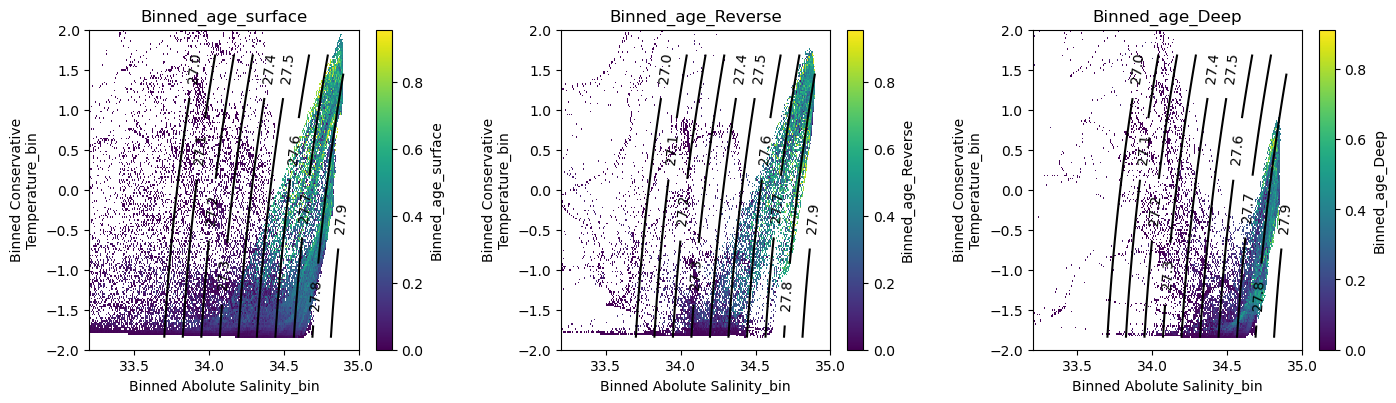

In [14]:
plt.figure(figsize=(16,4))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.subplot(1,3,1)
Filterhot=np.where(tbins<1.7)[0]
R0_levels=np.arange(27,29,0.1)
R0_TSAGE.plot(x='Binned Abolute Salinity_bin')
R0C = plt.contour(sbins,tbins[Filterhot],Sigma0[:,Filterhot].T,levels=R0_levels,linewidth=0.2,colors='black')
plt.clabel(R0C,R0C.levels, inline=True)
plt.title(R0_TSAGE.name)
plt.ylim(-2,2)
plt.xlim(33.2,35)

plt.subplot(1,3,2)
Filterhot=np.where(tbins<1.7)[0]
R1_levels=np.arange(27,29,0.1)
R1_TSAGE.plot(x='Binned Abolute Salinity_bin')
R1C = plt.contour(sbins,tbins[Filterhot],Sigma0[:,Filterhot].T,levels=R1_levels,linewidth=0.2,colors='black')
plt.clabel(R1C,R1C.levels, inline=True)
plt.title(R1_TSAGE.name)
plt.ylim(-2,2)
plt.xlim(33.2,35)


plt.subplot(1,3,3)
Filterhot=np.where(tbins<1.7)[0]
R2_levels=np.arange(27,29,0.1)
R2_TSAGE.plot(x='Binned Abolute Salinity_bin')
R2C = plt.contour(sbins,tbins[Filterhot],Sigma0[:,Filterhot].T,levels=R2_levels,linewidth=0.2,colors='black')
plt.clabel(R2C,R2C.levels, inline=True)
plt.title(R2_TSAGE.name)
plt.ylim(-2,2)
plt.xlim(33.2,35)